<a href="https://colab.research.google.com/github/ellenbeatryzbarone/Portfolio/blob/main/Covid19_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import plotly.express as px

# Carregar dados públicos (exemplo de dados disponíveis no Our World in Data)
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url)

# Filtrar dados do Brasil
brasil = df[df['iso_code'] == 'BRA']

# Agrupar por data e somar casos e mortes
brasil_time = brasil.groupby('date').agg({'new_cases':'sum', 'new_deaths':'sum'}).reset_index()

# Criar gráfico interativo de casos ao longo do tempo
fig = px.line(
    brasil_time,
    x='date',
    y=['new_cases', 'new_deaths'],
    labels={'value':'Número de casos', 'date':'Data'},
    title='Evolução diária de casos e mortes de COVID-19 no Brasil',
    template='plotly_dark'
)

fig.update_layout(
    legend_title_text='Tipo de dado',
    hovermode='x unified'
)

# Exibir
fig.show()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0067
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0039
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0031
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0034
Epoch 16/50
42/42 ━━━━━━━━━

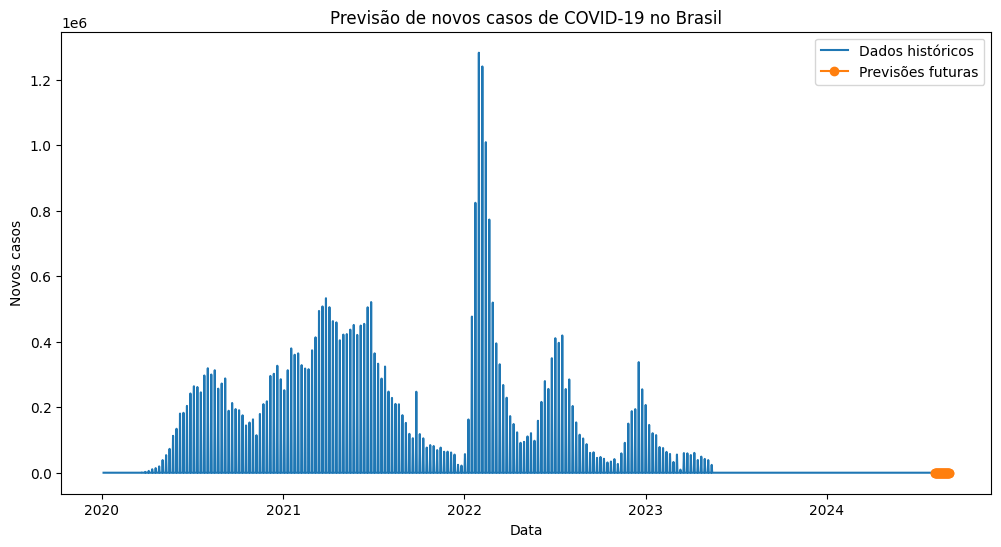

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Carregar dados
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df = pd.read_csv(url, parse_dates=['date'])

# Filtrar Brasil
brasil = df[df['iso_code'] == 'BRA'].copy()

# Filtrar até março de 2025
fim_periodo = pd.Timestamp('2025-03-31')
brasil = brasil[brasil['date'] <= fim_periodo]

# Agrupar por dia
brasil = brasil[['date', 'new_cases']].sort_values('date')

# Preencher dias sem casos (se houver)
brasil = brasil.set_index('date').asfreq('D', fill_value=0)

# Preparar os dados para o modelo
data = brasil['new_cases'].values
# Normalizar os dados
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Criar janelas de tempo para entrada do modelo
def create_dataset(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 14  # usar duas semanas de dados para prever o próximo dia
X, y = create_dataset(data_scaled, n_steps)

# Reshape para [samples, time steps, features]
X = X.reshape((X.shape[0], n_steps, 1))

# Dividir em treino e teste
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Criar modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Treinar
model.fit(X_train, y_train, epochs=50, verbose=1)

# Fazer previsão para os próximos 30 dias
prediction_period = 30
last_sequence = data_scaled[-n_steps:]  # último trecho de dados
predictions = []

for _ in range(prediction_period):
    pred_input = last_sequence.reshape((1, n_steps, 1))
    pred = model.predict(pred_input)
    predictions.append(pred[0,0])
    last_sequence = np.append(last_sequence[1:], pred, axis=0)  # atualizar a sequencia

# Desfazer a normalização
predictions_descaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Plotar resultados
import matplotlib.dates as mdates
future_dates = pd.date_range(brasil.index[-1] + pd.Timedelta(days=1), periods=prediction_period)

plt.figure(figsize=(12,6))
plt.plot(brasil.index, data, label='Dados históricos')
plt.plot(future_dates, predictions_descaled, label='Previsões futuras', marker='o')
plt.xlabel('Data')
plt.ylabel('Novos casos')
plt.title('Previsão de novos casos de COVID-19 no Brasil')
plt.legend()
plt.show()